### Create a mask with folium

1. plot polygons for MO, IL  
2. get polygon for St. Louis City County  
3. subtract \#2 from \#1

In [1]:
# IMPORTS
import geopandas as gpd
import pandas as pd

# import os
# import urllib.request
# import requests
# import shutil
# from pathlib import Path
# from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib import pyplot

import folium

from shapely.geometry import Point, Polygon

# from geopandas.tools import overlay

# from geopy.geocoders import Nominatim # for geocoding

# import random # for obscuring sex offender names

# a few more imports specfic to the database process
# import geoalchemy2 
import getpass

import psycopg2
import numpy
from psycopg2.extensions import adapt, register_adapter, AsIs

from sqlalchemy import create_engine


In [2]:
# get user password for connecting to the db
mypasswd = getpass.getpass()

········


In [20]:
# set up db connection
conn = psycopg2.connect(database = 'cappsds_psmd39', 
                              user = 'psmd39', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)

In [21]:
# establish cursor and read the existing tables
cursor = conn.cursor()

cursor.execute("""SELECT relname FROM pg_class WHERE relkind='r'
                  AND relname !~ '^(pg_|sql_)';""") # "rel" is short for relation.

tables = [i[0] for i in cursor.fetchall()] # A list() of tables.
tables.sort()
tables

['country_borders',
 'gadm_admin_borders',
 'geonames_feature',
 'msorfailedgeocoding',
 'msorfailedgeocodingv2',
 'spatial_ref_sys',
 'stlchildcare',
 'stlnonrestrictedresidential',
 'stlnonrestrictedresparcels',
 'stlpubschools',
 'stlpvtschools',
 'stlresparcels',
 'stlrestrictedflat',
 'stlsexoffenders',
 'stlzoning']

In [5]:
cursor.execute("""SELECT table_schema, table_name 
                        FROM information_schema.tables
                        WHERE table_schema !~ '^(information_)' AND table_name !~ '^(pg_|sql_)';""") 
cursor.fetchall()

[('public', 'stlpubschools'),
 ('public', 'geography_columns'),
 ('public', 'geometry_columns'),
 ('public', 'spatial_ref_sys'),
 ('public', 'raster_columns'),
 ('public', 'raster_overviews'),
 ('public', 'stlpvtschools'),
 ('public', 'stlchildcare'),
 ('public', 'stlzoning'),
 ('public', 'stlrestrictedflat'),
 ('public', 'stlsexoffenders'),
 ('geospatial', 'country_borders'),
 ('geospatial', 'gadm_admin_borders'),
 ('public', 'stlnonrestrictedresidential'),
 ('public', 'stlnonrestrictedresparcels'),
 ('public', 'stlresparcels'),
 ('public', 'msorfailedgeocodingv2'),
 ('geospatial', 'geonames_feature'),
 ('public', 'msorfailedgeocoding')]

In [10]:
# conn.close()

In [6]:
# BASIC SELECT TO A DATAFRAME 
# query the table and read data into a df 
sql = "select * from geospatial.gadm_admin_borders LIMIT 10;"
msor_nogeo = pd.read_sql_query(sql, conn)
print(msor_nogeo.shape)
msor_nogeo.head()

(10, 50)


,gid,objectid,iso,name_0,name_1,varname_1,nl_name_1,hasc_1,fips_1,cc_1,...,validto_4,remarks_4,name_5,type_5,engtype_5,validfr_5,validto_5,shape_leng,shape_area,the_geom
0,1,1,RUS,Russia,Sakha,Republic of Sakha|Yakutia-Sakha|Yakutsk|Yakut ...,?????????? ????,RU.SK,RS63,6500,...,None,None,None,None,None,None,None,59.472017,11.994040,0106000020E61000001B00000001030000000100000012...
1,2,2,RUS,Russia,Sakha,Republic of Sakha|Yakutia-Sakha|Yakutsk|Yakut ...,?????????? ????,RU.SK,RS63,6500,...,None,None,None,None,None,None,None,34.953069,13.839200,0106000020E61000000C00000001030000000100000029...
2,3,3,RUS,Russia,Taymyr,Dolgan-Nenets|Dolgano-Nenetskiy A.Okr.|Taymyrs...,?????????? ???,RU.TM,RS74,6202,...,None,None,None,None,None,None,None,47.936798,37.859411,0106000020E6100000010000000103000000010000006B...
3,4,4,CAN,Canada,Nunavut,None,None,CA.NU,CA14,None,...,None,None,None,None,None,None,None,494.169084,115.482927,0106000020E6100000E7030000010300000001000000CE...
4,5,5,RUS,Russia,Sakha,Republic of Sakha|Yakutia-Sakha|Yakutsk|Yakut ...,?????????? ????,RU.SK,RS63,6500,...,None,None,None,None,None,None,None,106.003828,45.049222,0106000020E61000009100000001030000000100000007...


In [69]:
# SELECT TO A GEODATAFRAME
# create sql statement and pull from db into a geopandas dataframe
sql = """SELECT * FROM geospatial.gadm_admin_borders 
            WHERE iso = 'USA' AND varname_1 = 'MO' and name_2 = 'Saint Louis'
            LIMIT 1000;"""
gdf1 = gpd.read_postgis(sql, conn, geom_col='the_geom')
# gpd_childcare = gpd_childcare.drop(columns='geometry') # drop the duplicate geometry column
gdf1.head()


,gid,objectid,iso,name_0,name_1,varname_1,nl_name_1,hasc_1,fips_1,cc_1,...,validto_4,remarks_4,name_5,type_5,engtype_5,validfr_5,validto_5,shape_leng,shape_area,the_geom
0,18144,18153,USA,United States,Missouri,MO,None,US.MO,US29,None,...,None,None,None,None,None,None,None,2.131524,0.156924,"MULTIPOLYGON (((-90.73583 38.48316, -90.73193 ..."


<AxesSubplot:>

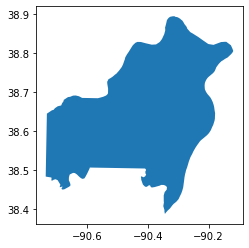

In [71]:
gdf1.plot()

In [58]:
gdf1.dtypes

gid              int64
objectid         int64
iso             object
name_0          object
name_1          object
varname_1       object
nl_name_1       object
hasc_1          object
fips_1          object
cc_1            object
type_1          object
engtype_1       object
validfr_1       object
validto_1       object
remarks_1       object
name_2          object
varname_2       object
nl_name_2       object
hasc_2          object
fips_2          object
cc_2            object
type_2          object
engtype_2       object
validfr_2       object
validto_2       object
remarks_2       object
name_3          object
varname_3       object
nl_name_3       object
hasc_3          object
type_3          object
engtype_3       object
validfr_3       object
validto_3       object
remarks_3       object
name_4          object
varname_4       object
type_4          object
engtype_4       object
validfr_4       object
validto_4       object
remarks_4       object
name_5          object
type_5     

In [66]:
sorted(gdf1['name_2'].unique())

['Adair',
 'Andrew',
 'Atchison',
 'Audrain',
 'Barry',
 'Barton',
 'Bates',
 'Benton',
 'Bollinger',
 'Boone',
 'Buchanan',
 'Butler',
 'Caldwell',
 'Callaway',
 'Camden',
 'Cape Girardeau',
 'Carroll',
 'Carter',
 'Cass',
 'Cedar',
 'Chariton',
 'Christian',
 'Clark',
 'Clay',
 'Clinton',
 'Cole',
 'Cooper',
 'Crawford',
 'Dade',
 'Dallas',
 'Daviess',
 'De Kalb',
 'Dent',
 'Douglas',
 'Dunklin',
 'Franklin',
 'Gasconade',
 'Gentry',
 'Greene',
 'Grundy',
 'Harrison',
 'Henry',
 'Hickory',
 'Holt',
 'Howard',
 'Howell',
 'Iron',
 'Jackson',
 'Jasper',
 'Jefferson',
 'Johnson',
 'Knox',
 'Laclede',
 'Lafayette',
 'Lawrence',
 'Lewis',
 'Lincoln',
 'Linn',
 'Livingston',
 'Macon',
 'Madison',
 'Maries',
 'Marion',
 'McDonald',
 'Mercer',
 'Miller',
 'Mississippi',
 'Moniteau',
 'Monroe',
 'Montgomery',
 'Morgan',
 'New Madrid',
 'Newton',
 'Nodaway',
 'Oregon',
 'Osage',
 'Ozark',
 'Pemiscot',
 'Perry',
 'Pettis',
 'Phelps',
 'Pike',
 'Platte',
 'Polk',
 'Pulaski',
 'Putnam',
 'Ralls',

In [19]:
conn.close()

In [ ]:
m_sm = folium.Map([38.63, -90.22], tiles='openstreetmap', zoom_start=13)

# set the details of the style for our polygons
style_function = lambda x: {
    'fillColor': AsdTotal_colormap(x['properties']['AsdTotal']), # apply our colormap here
    'color': 'black', # polygon outlines
    'weight': 0.5, # outline weight
    'fillOpacity': 0.7
}


folium.GeoJson(
    prcl_plot_sm,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['HANDLE', 'AsdTotal'],
        aliases=['Handle', 'Assessed Total']
    )
).add_to(m_sm)

m_sm